### Before continuing, make sure you have Wiki DB installed and in the same directory as this program. See README for link

## Description of Data Set and CNN goal
The Convolutional Neural Network (CNN) built in this project aims to recognize and classify images of faces based on the provided metadata. <br>
Specifically, the CNN will be trained to:
Identify the Gender and Predict the Age of a person based on their face.

## Import Dependencies 

In [251]:
import scipy.io
import os
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.models import Model




## Load Relevant Metadata

In [252]:
# Path to the local dataset directory
import numpy as np


data_dir = './wiki'

# Path to the metadata file
metadata_file = os.path.join(data_dir, 'wiki.mat')

# Load the metadata from the .mat file
metadata = scipy.io.loadmat(metadata_file)
# Extract the relevant metadata
wiki_data = metadata['wiki'][0, 0]
image_paths = wiki_data['full_path'][0]
names = wiki_data['name'][0]
genders = wiki_data['gender'][0]
birthdates = wiki_data['dob'][0]
photo_taken = wiki_data['photo_taken'][0]

# Calculate age
# Function to convert MATLAB serial date number to a readable date
def convert_dob(dob):
    reference_date = datetime(1, 1, 1)
    days_since_reference = int(dob)
    actual_date = reference_date + timedelta(days=days_since_reference - 366)
    return actual_date.strftime("%Y-%m-%d")  # Format as Year-Month-Day

# Calculate ages
ages = []
for dob, photo_year in zip(birthdates, photo_taken):
    birthdate = convert_dob(dob)
    age = photo_year - int(birthdate[:4])

    ages.append(age)

ages = np.array(ages)
# MATLAB's reference date (0 days since year 0)
reference_date = datetime(1, 1, 1)



## Visualize 5 examples 

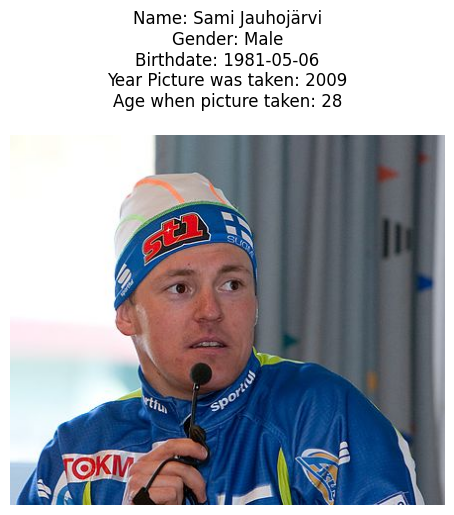

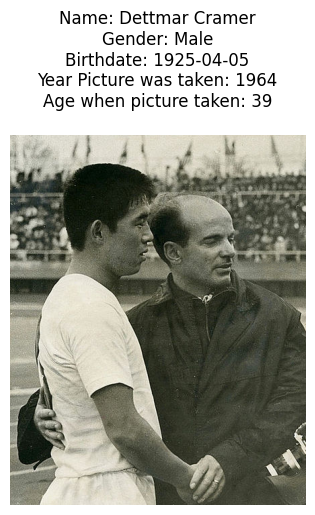

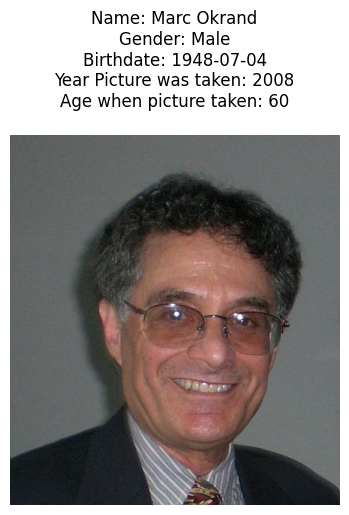

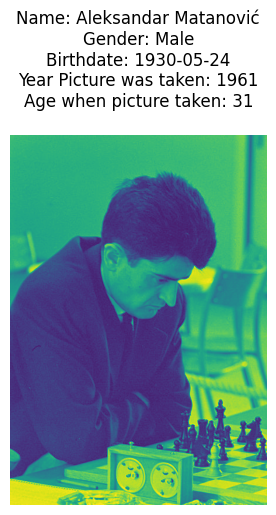

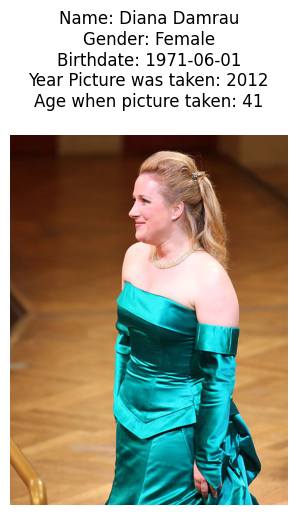

In [253]:

# Function to display an image with its metadata
def display_image_with_metadata(image_path, name, gender, dob, photo_taken, age):
    # Construct the full image path
    full_image_path = os.path.join(data_dir, image_path[0])
    birthdate_str = convert_dob(dob)

    # Open and display the image
    image = Image.open(full_image_path)
    plt.imshow(image)
    plt.imshow(image)
    title = (f"Name: {name[0]}\n"
            f"Gender: {'Male' if gender == 1 else 'Female' }\n"
             f"Birthdate: {birthdate_str}\n"
             f"Year Picture was taken: {photo_taken}\n"
             # Can be off by 1 year, since db does not have month/day picture was taken
             f"Age when picture taken: {age}\n"
             )
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display a few images with their metadata
for i in range(5):
    display_image_with_metadata(image_paths[i], names[i], genders[i], birthdates[i], photo_taken[i], ages[i])
    

## Split Data


In [254]:
# Split data between training and testing
# Check if the directory with split data already exists
if not os.path.exists("./wiki_split_data"):
    # Split data between training and testing
    splitfolders.ratio('./wiki', output="./wiki_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))


## Build Model

In [255]:
# Input layer
input_layer = Input(shape=(64, 64, 3))

# Shared layers
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)

# Output layers
age_output = Dense(units=1, activation='linear', name='age_output')(x)  # Regression for age
gender_output = Dense(units=1, activation='sigmoid', name='gender_output')(x)  # Binary classification for gender

# Define the model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Print the model summary
model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_37[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_35          │ (None, 131072)    │          0 │ conv2d_38[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │ 16,777,344 │ flatten_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dense_35[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,778,498 (64.00 MB)

 Trainable params: 16,778,498 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [256]:
from tensorflow import keras
from tensorflow.data import AUTOTUNE
# wiki_data contains ('dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score')
# Relevant features are 'dob', 'photo_taken', 'gender'
# Feature engineering and give model photo taken - dob as input, or just let it learn from the data 
# somehow map x to y





AttributeError: in user code:

    File "/var/folders/yl/wjfz8mgx57s1mws2vfhh23000000gn/T/ipykernel_51803/2004482940.py", line 16, in process_path  *
        file_name = file_name.numpy().decode('utf-8')

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'
